In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, LSTM, Dense, Dropout
import keras_tuner as kt 
import matplotlib.pyplot as plt

In [1]:
# === 1. Imports ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU
import warnings
warnings.filterwarnings("ignore")

# === 2. Load and Clean Data ===
df = pd.read_excel("Colombia.xlsx")
df = df[['Year', 'Land_used(ha)']].copy()
df['Land_used(ha)'] = (
    df['Land_used(ha)']
    .astype(str)
    .str.replace(',', '')
    .str.replace('\xa0', '')
    .astype(float)
)
df = df.sort_values('Year').reset_index(drop=True)

# === 3. Create Lag Features ===
def create_lag_features(series, window=3):
    X, y = [], []
    for i in range(window, len(series)):
        X.append(series[i-window:i])
        y.append(series[i])
    return np.array(X), np.array(y)

land_used = df['Land_used(ha)'].values
years = df['Year'].tolist()
X_train, y_train = create_lag_features(land_used[:13], window=3)  # 2008–2010 → predict 2011–2021

# === 4. Train Base Models ===
rf = RandomForestRegressor(n_estimators=100, random_state=42)
xgb = XGBRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
xgb.fit(X_train, y_train)

# === 5. Train LSTM & GRU ===
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_train)
y_scaled = scaler.fit_transform(y_train.reshape(-1, 1))

# LSTM
model_lstm = Sequential([
    LSTM(50, activation='relu', input_shape=(3,1)),
    Dense(1)
])
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_scaled.reshape(-1, 3, 1), y_scaled, epochs=100, verbose=0)

# GRU
model_gru = Sequential([
    GRU(50, activation='relu', input_shape=(3,1)),
    Dense(1)
])
model_gru.compile(optimizer='adam', loss='mse')
model_gru.fit(X_scaled.reshape(-1, 3, 1), y_scaled, epochs=100, verbose=0)

# === 6. Recursive Base Predictions for 2011–2022 ===
series = list(land_used[:3])  # Start from 2008–2010
actual = land_used[3:]       # Ground truth: 2011–2022
pred_years = years[3:]

rf_preds, xgb_preds, arima_preds, lstm_preds, gru_preds = [], [], [], [], []
stacked_features = []

for i in range(len(actual)):
    input_seq = np.array(series[-3:]).reshape(1, -1)

    # Random Forest & XGBoost
    rf_pred = rf.predict(input_seq)[0]
    xgb_pred = xgb.predict(input_seq)[0]

    # ARIMA
    model_arima = ARIMA(series, order=(2, 1, 0))
    model_fit = model_arima.fit()
    arima_pred = model_fit.forecast()[0]

    # LSTM & GRU
    input_seq_scaled = scaler.transform(np.array(series[-3:]).reshape(-1, 1)).reshape((1, 3, 1))
    lstm_pred = scaler.inverse_transform(model_lstm.predict(input_seq_scaled, verbose=0))[0][0]
    gru_pred = scaler.inverse_transform(model_gru.predict(input_seq_scaled, verbose=0))[0][0]

    # Save base model predictions
    rf_preds.append(rf_pred)
    xgb_preds.append(xgb_pred)
    arima_preds.append(arima_pred)
    lstm_preds.append(lstm_pred)
    gru_preds.append(gru_pred)

    # Collect features for stacking
    stacked_features.append([arima_pred, rf_pred, xgb_pred, lstm_pred, gru_pred])

    # Update sequence for next iteration (using rf_pred arbitrarily)
    series.append(rf_pred)

# === 7. Stacking: Train Meta Model ===
meta_X = np.array(stacked_features)
meta_y = np.array(actual)
meta_model = LinearRegression()
meta_model.fit(meta_X, meta_y)
stacked_preds = meta_model.predict(meta_X)

# === 8. Evaluation Function ===
def evaluate(y_true, y_pred):
    return {
        "R2": r2_score(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "MAE": mean_absolute_error(y_true, y_pred)
    }

# === 9. Evaluation Table ===
results = {
    "ARIMA": evaluate(actual, arima_preds),
    "Random Forest": evaluate(actual, rf_preds),
    "XGBoost": evaluate(actual, xgb_preds),
    "LSTM": evaluate(actual, lstm_preds),
    "GRU": evaluate(actual, gru_preds),
    "Stacked Ensemble": evaluate(actual, stacked_preds)
}
results_df = pd.DataFrame(results).T
print("\nModel Evaluation Table:\n", results_df)

# === 10. Year-wise Prediction Table ===
pred_table = pd.DataFrame({
    "Year": pred_years,
    "Actual": actual,
    "ARIMA": arima_preds,
    "Random Forest": rf_preds,
    "XGBoost": xgb_preds,
    "LSTM": lstm_preds,
    "GRU": gru_preds,
    "Stacked Ensemble": stacked_preds
})
print("\nYear-wise Prediction Table:\n", pred_table.to_string(index=False))



Model Evaluation Table:
                         R2           RMSE           MAE
ARIMA            -0.583030  100563.654863  71405.060980
Random Forest    -0.580031  100468.358078  71941.825000
XGBoost          -0.037112   81397.161306  38566.778646
LSTM              0.082626   76554.313995  42431.335938
GRU               0.058973   77534.955237  51138.169271
Stacked Ensemble  0.133359   74407.383702  47454.253637

Year-wise Prediction Table:
  Year   Actual         ARIMA  Random Forest      XGBoost         LSTM          GRU  Stacked Ensemble
 2011 381961.0 349187.212390      391176.69 381961.09375 395711.09375 369229.71875     361766.527747
 2012 396532.0 392801.916373      398910.21 396532.03125 396736.18750 372477.62500     389222.435372
 2013 406204.0 398910.190973      404995.07 406204.03125 399097.28125 377856.96875     412641.762544
 2014 401132.0 404258.648526      402670.89 402286.53125 404771.15625 386456.43750     417545.457858
 2015 409462.0 402223.209209      423744.07 409

In [4]:
# === 1. Imports ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU
import warnings
warnings.filterwarnings("ignore")

# === 2. Load and Clean Data ===
df = pd.read_excel("Colombia_full.xlsx")
df = df[['Year', 'Land_used(ha)']].copy()
df['Land_used(ha)'] = df['Land_used(ha)'].astype(str).str.replace(',', '').str.replace('\xa0', '').astype(float)
df = df.sort_values('Year').reset_index(drop=True)

# === 3. Handle Outliers Using IQR Clipping ===
Q1 = df['Land_used(ha)'].quantile(0.25)
Q3 = df['Land_used(ha)'].quantile(0.75)
IQR = Q3 - Q1
df['Land_used(ha)'] = np.clip(df['Land_used(ha)'], Q1 - 1.5 * IQR, Q3 + 1.5 * IQR)

# === 4. Create Lag Features ===
def create_lag_features(series, window=3):
    X, y = [], []
    for i in range(window, len(series)):
        X.append(series[i-window:i])
        y.append(series[i])
    return np.array(X), np.array(y)

years = df['Year'].tolist()
start_idx = years.index(2005)

land_used = df['Land_used(ha)'].values

train_start = years.index(2005)  # Need 3 years before first prediction
train_end = years.index(2023) + 1  # inclusive end index

X_train, y_train = create_lag_features(land_used[train_start:train_end], window=3)
pred_years = years[train_start + 3:train_end]  # 2008 to 2023
actual = land_used[train_start + 3:train_end]



# === 5. Hyperparameter Tuning ===
def tune_model(model, param_grid):
    grid = GridSearchCV(model, param_grid, cv=3)
    grid.fit(X_train, y_train)
    return grid.best_estimator_

models = {}

models['Random Forest'] = tune_model(RandomForestRegressor(random_state=42), {
    'n_estimators': [100, 200], 'max_depth': [None, 5, 10]
})

models['XGBoost'] = tune_model(XGBRegressor(random_state=42, verbosity=0), {
    'n_estimators': [100, 200], 'learning_rate': [0.05, 0.1], 'max_depth': [3, 5]
})

models['Decision Tree'] = tune_model(DecisionTreeRegressor(random_state=42), {
    'max_depth': [3, 5, 10]
})

models['SVM'] = tune_model(SVR(), {
    'C': [0.1, 1, 10], 'kernel': ['rbf', 'linear']
})

models['Gradient Boost'] = tune_model(GradientBoostingRegressor(random_state=42), {
    'n_estimators': [100, 200], 'learning_rate': [0.05, 0.1], 'max_depth': [3, 5]
})

# === 6. Train LSTM & GRU ===
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_train)
y_scaled = scaler.fit_transform(y_train.reshape(-1, 1))

model_lstm = Sequential([LSTM(50, activation='relu', input_shape=(3,1)), Dense(1)])
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_scaled.reshape(-1, 3, 1), y_scaled, epochs=100, verbose=0)

model_gru = Sequential([GRU(50, activation='relu', input_shape=(3,1)), Dense(1)])
model_gru.compile(optimizer='adam', loss='mse')
model_gru.fit(X_scaled.reshape(-1, 3, 1), y_scaled, epochs=100, verbose=0)

# === 7. Recursive Forecast ===
series = list(land_used[start_idx-3:start_idx])
preds = {name: [] for name in models}
arima_preds, lstm_preds, gru_preds = [], [], []
stacked_features = []

for _ in range(16):  # Predict 2008 to 2022
    input_seq = np.array(series[-3:]).reshape(1, -1)

    pred_row = []

    # Classical ML Models
    for name, model in models.items():
        pred = model.predict(input_seq)[0]
        preds[name].append(pred)
        pred_row.append(pred)

    # ARIMA
    model_arima = ARIMA(series, order=(2, 1, 0))
    arima_pred = model_arima.fit().forecast()[0]
    arima_preds.append(arima_pred)
    pred_row.append(arima_pred)

    # LSTM & GRU
    input_seq_scaled = scaler.transform(np.array(series[-3:]).reshape(-1, 1)).reshape((1, 3, 1))
    lstm_pred = scaler.inverse_transform(model_lstm.predict(input_seq_scaled, verbose=0))[0][0]
    gru_pred = scaler.inverse_transform(model_gru.predict(input_seq_scaled, verbose=0))[0][0]
    lstm_preds.append(lstm_pred)
    gru_preds.append(gru_pred)
    pred_row.extend([lstm_pred, gru_pred])

    stacked_features.append(pred_row)
    series.append(pred_row[0])  # arbitrary update, could be mean(pred_row)

# === 8. Stacking Ensemble ===
meta_X = np.array(stacked_features)
meta_y = np.array(actual)
meta_model = LinearRegression()
meta_model.fit(meta_X, meta_y)
stacked_preds = meta_model.predict(meta_X)

# === 9. Evaluation Function ===
def evaluate(y_true, y_pred):
    return {
        "R2": r2_score(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "MAE": mean_absolute_error(y_true, y_pred)
    }

# === 10. Evaluation Table ===
results = {
    "ARIMA": evaluate(actual, arima_preds),
    "LSTM": evaluate(actual, lstm_preds),
    "GRU": evaluate(actual, gru_preds),
    "Stacked Ensemble": evaluate(actual, stacked_preds)
}
for name in preds:
    results[name] = evaluate(actual, preds[name])

results_df = pd.DataFrame(results).T
print("\n📊 Model Evaluation Table:\n", results_df)

# === 11. Year-wise Table ===
pred_table = pd.DataFrame({
    "Year": pred_years,
    "Actual": actual,
    "ARIMA": arima_preds,
    "LSTM": lstm_preds,
    "GRU": gru_preds,
    "Stacked Ensemble": stacked_preds
})
for name in preds:
    pred_table[name] = preds[name]

print("\n📅 Year-wise Prediction Table:\n", pred_table.to_string(index=False))



📊 Model Evaluation Table:
                         R2          RMSE           MAE
ARIMA            -0.001900  48504.560504  30896.616507
LSTM              0.005995  48313.070729  29923.455078
GRU               0.007512  48276.211455  29979.519531
Stacked Ensemble  0.347839  39133.436043  25831.555486
Random Forest    -0.002438  48517.594354  29153.514531
XGBoost          -0.009573  48689.954015  30064.443359
Decision Tree     0.025935  47826.032829  28808.089286
SVM              -0.042305  49472.962724  31400.123986
Gradient Boost   -0.035815  49318.697107  30156.528323

📅 Year-wise Prediction Table:
  Year   Actual         ARIMA         LSTM          GRU  Stacked Ensemble  Random Forest      XGBoost  Decision Tree           SVM  Gradient Boost
 2008 383388.0 399555.078295 403357.18750 403820.53125     377614.450634    404754.6350 401638.65625  404294.142857 402121.293922   401666.392564
 2009 379505.0 404912.742552 404592.25000 405227.18750     428646.614545    403791.2900 405361.468

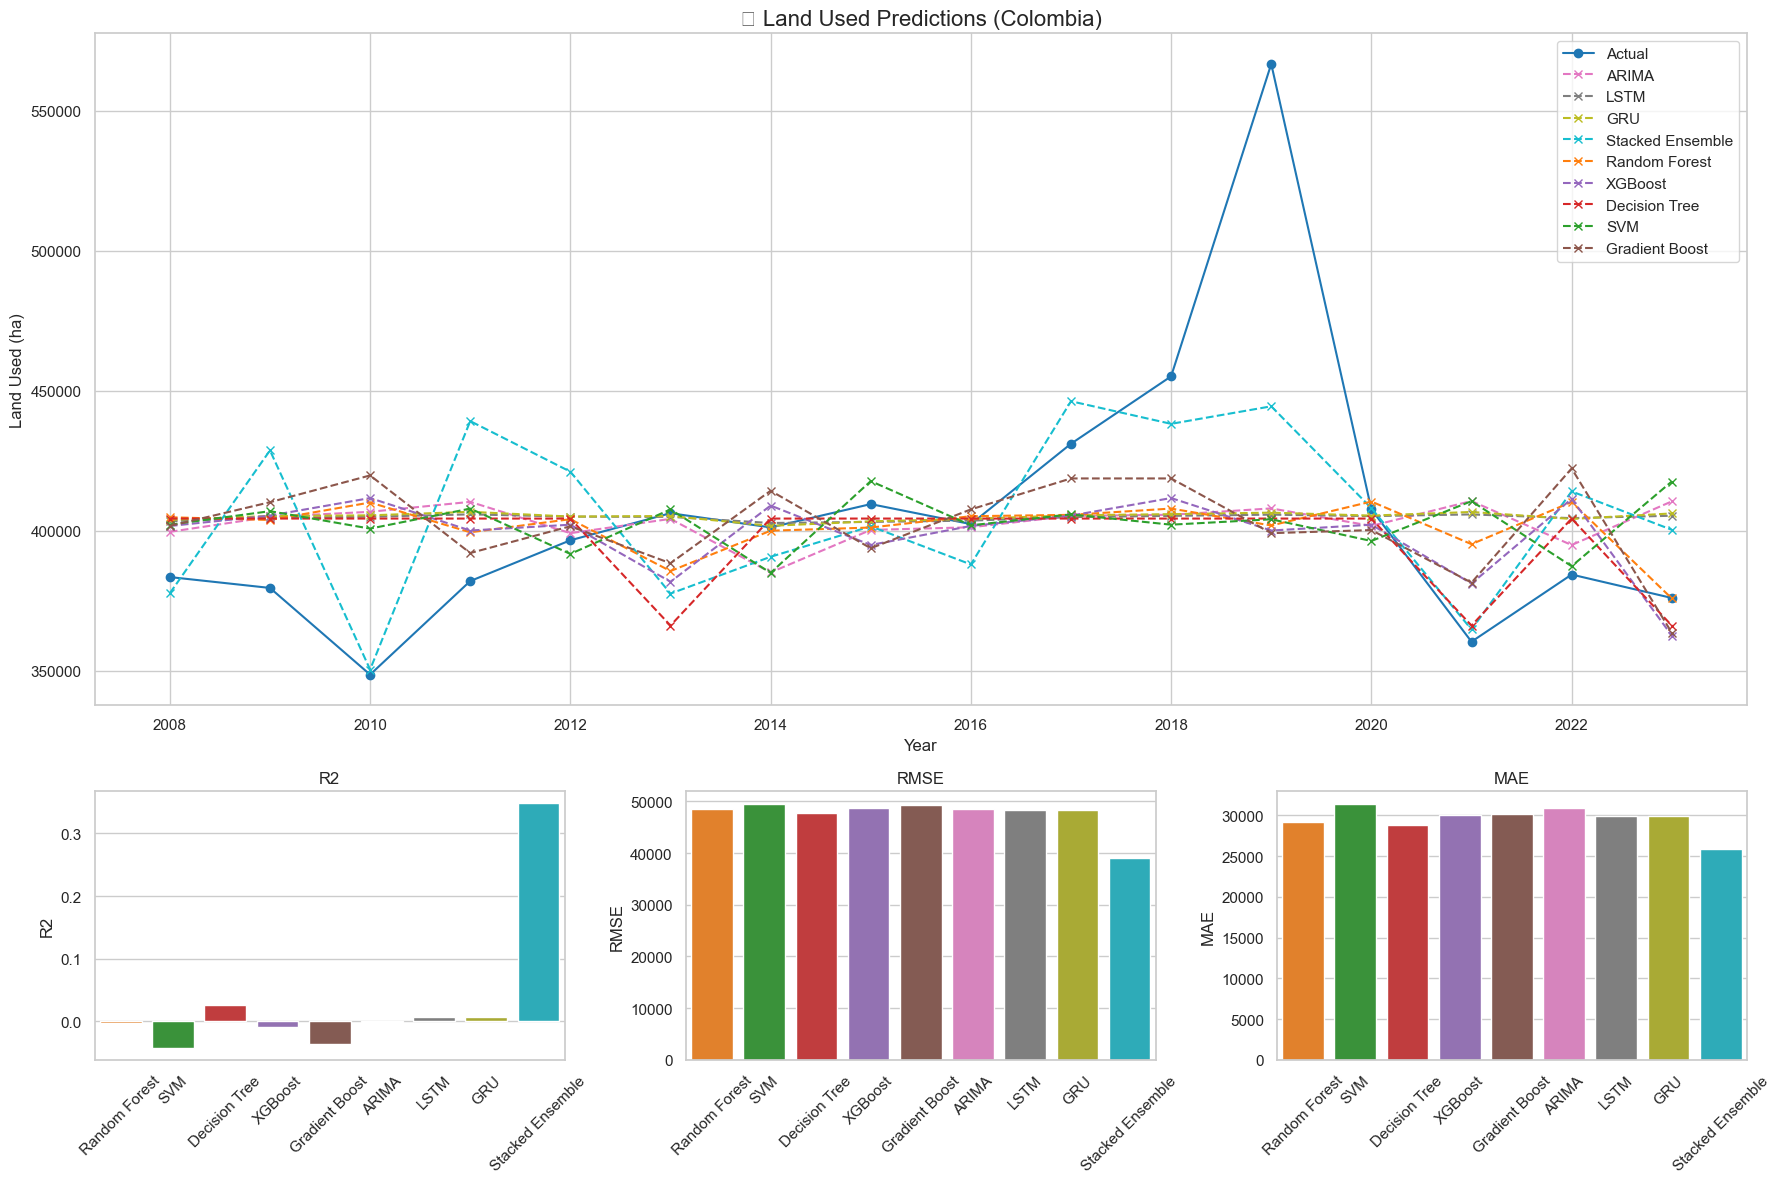

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# === 1. Define consistent colors for all models ===
fixed_colors = {
    'Actual': '#1f77b4',             # blue
    'Random Forest': '#ff7f0e',      # orange
    'SVM': '#2ca02c',                # green
    'Decision Tree': '#d62728',     # red
    'XGBoost': '#9467bd',           # purple
    'Gradient Boost': '#8c564b',    # brown
    'ARIMA': '#e377c2',             # pink
    'LSTM': '#7f7f7f',              # gray
    'GRU': '#bcbd22',               # olive
    'Stacked Ensemble': '#17becf'   # cyan
}

# === 2. Prepare data ===
models_to_plot = list(results_df.index)
results_df_plot = results_df.reset_index().rename(columns={'index': 'Model'})
pred_table_sorted = pred_table.sort_values("Year")

# === 3. Set plot style and layout ===
sns.set(style="whitegrid")
plt.figure(figsize=(18, 12))
gs = plt.GridSpec(2, 3, height_ratios=[2.5, 1])

# === 4. Line Plot: Actual vs Predicted ===
ax1 = plt.subplot(gs[0, :])
ax1.plot(pred_table_sorted['Year'], pred_table_sorted['Actual'],
         label='Actual', marker='o', color=fixed_colors['Actual'])

for model in models_to_plot:
    ax1.plot(pred_table_sorted['Year'], pred_table_sorted[model],
             label=model, linestyle='--', marker='x', color=fixed_colors.get(model, None))

ax1.set_title("📉 Land Used Predictions (Colombia)", fontsize=16)
ax1.set_xlabel("Year")
ax1.set_ylabel("Land Used (ha)")
ax1.legend()

# === 5. Bar Plots for R², RMSE, MAE ===
metrics = ['R2', 'RMSE', 'MAE']
for i, metric in enumerate(metrics):
    ax = plt.subplot(gs[1, i])
    # Preserve model color order
    order = [m for m in fixed_colors if m in results_df_plot['Model'].values]
    sns.barplot(data=results_df_plot, x='Model', y=metric, ax=ax,
                palette=[fixed_colors[m] for m in order], order=order)
    ax.set_title(metric)
    ax.set_xlabel('')
    ax.set_ylabel(metric)
    ax.tick_params(axis='x', rotation=45)

# === 6. Final Display ===
plt.tight_layout()
plt.show()


📊 New Model Evaluation:
                         R2       RMSE       MAE
Random Forest     0.739731   6.467796  4.992021
SVR               0.466834   9.257135  5.132410
Ridge             0.365399  10.099401  6.727672
XGBoost           0.996802   0.716987  0.431705
LSTM              0.720228   6.705758  5.908340
GRU               0.593366   8.084389  6.654056
Stacked Ensemble  0.999899   0.127275  0.107873


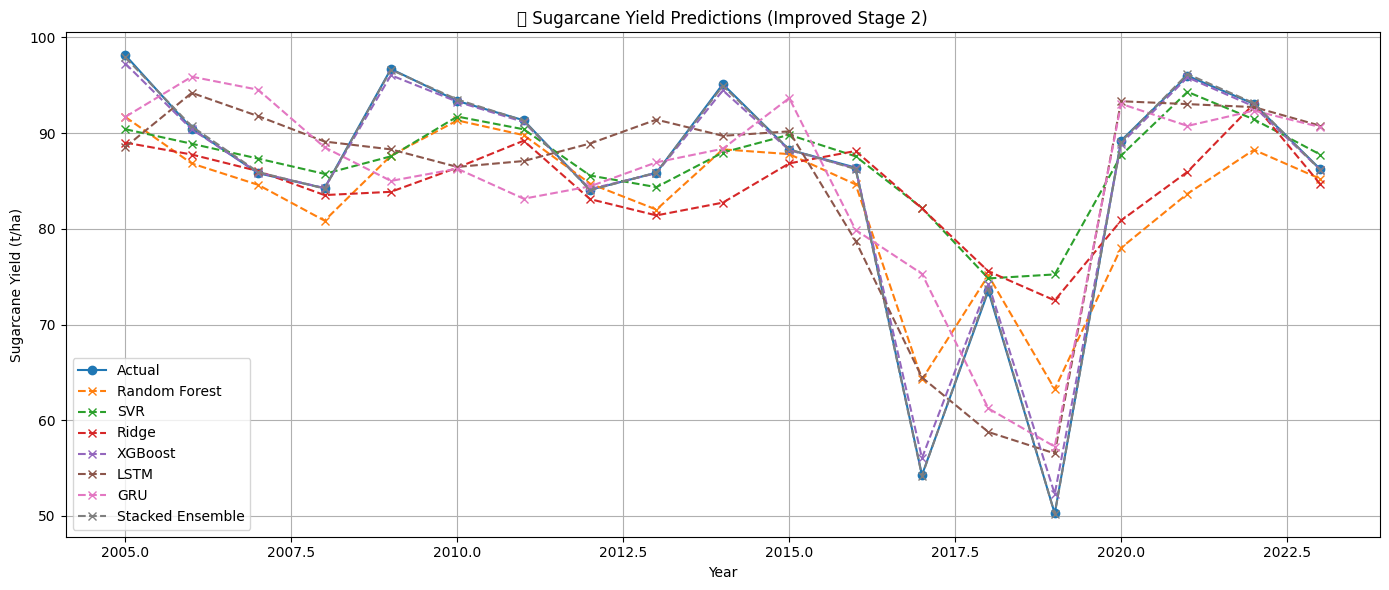

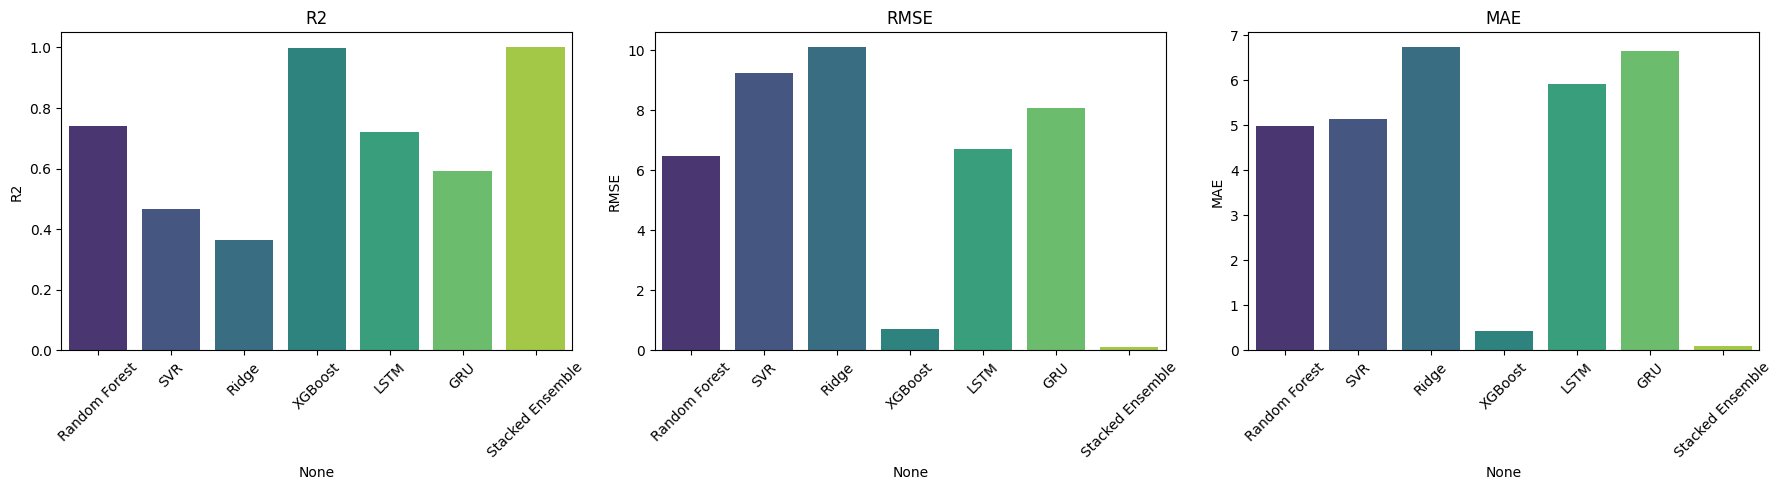

In [8]:
# === 1. Imports ===
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings("ignore")

# === 2. Load and Clean ===
df = pd.read_excel("Colombia_full.xlsx")
df = df[['Year', 'Land_used(ha)', 'Sugarcane_Yield(t/ha)']].copy()
df['Land_used(ha)'] = df['Land_used(ha)'].astype(str).str.replace(',', '').str.replace('\xa0', '').astype(float)
df['Sugarcane_Yield(t/ha)'] = df['Sugarcane_Yield(t/ha)'].astype(str).str.replace(',', '').str.replace('\xa0', '').astype(float)
df = df.sort_values('Year').reset_index(drop=True)

# === 3. Lag Feature Creation ===
def create_features(land_series, yield_series, window=5):
    X, y = [], []
    for i in range(window, len(land_series)):
        features = list(land_series[i-window:i]) + list(yield_series[i-window:i])
        X.append(features)
        y.append(yield_series[i])
    return np.array(X), np.array(y)

land = df['Land_used(ha)'].values
yield_ = df['Sugarcane_Yield(t/ha)'].values
years = df['Year'].tolist()

train_start = years.index(2000)
train_end = years.index(2023) + 1

X_train, y_train = create_features(land[train_start:train_end], yield_[train_start:train_end], window=5)
pred_years = years[train_start + 5:train_end]
actual = y_train.copy()

# === 4. Log-Transform Target ===
y_train_log = np.log1p(y_train)

# === 5. Standardize ===
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X_train)
y_scaled = scaler_y.fit_transform(y_train_log.reshape(-1, 1)).ravel()

# === 6. Model Training ===
def tune_model(model, param_grid):
    grid = GridSearchCV(model, param_grid, cv=3)
    grid.fit(X_scaled, y_scaled)
    return grid.best_estimator_

models = {
    'Random Forest': tune_model(RandomForestRegressor(random_state=0), {
        'n_estimators': [100], 'max_depth': [5, 10, None]
    }),
    'SVR': tune_model(SVR(), {'C': [1, 10], 'kernel': ['rbf']}),
    'Ridge': tune_model(Ridge(), {'alpha': [0.1, 1.0, 10]}),
    'XGBoost': tune_model(XGBRegressor(random_state=0, verbosity=0), {
        'n_estimators': [100], 'max_depth': [3, 5], 'learning_rate': [0.05, 0.1]
    })
}

# === 7. LSTM & GRU Models ===
X_seq = X_scaled.reshape(-1, 10, 1)  # 5 land + 5 yield

model_lstm = Sequential([LSTM(50, activation='relu', input_shape=(10, 1)), Dense(1)])
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_seq, y_scaled, epochs=100, verbose=0)

model_gru = Sequential([GRU(50, activation='relu', input_shape=(10, 1)), Dense(1)])
model_gru.compile(optimizer='adam', loss='mse')
model_gru.fit(X_seq, y_scaled, epochs=100, verbose=0)

# === 8. Predictions ===
preds = {}
X_seq = X_scaled.reshape(-1, 10, 1)

for name, model in models.items():
    y_pred_log = model.predict(X_scaled)
    y_pred = np.expm1(scaler_y.inverse_transform(y_pred_log.reshape(-1, 1)).ravel())
    preds[name] = y_pred

lstm_pred_scaled = model_lstm.predict(X_seq, verbose=0)
lstm_preds = np.expm1(scaler_y.inverse_transform(lstm_pred_scaled).ravel())

gru_pred_scaled = model_gru.predict(X_seq, verbose=0)
gru_preds = np.expm1(scaler_y.inverse_transform(gru_pred_scaled).ravel())

preds['LSTM'] = lstm_preds
preds['GRU'] = gru_preds

# === 9. Stacked Ensemble ===
meta_X = np.column_stack(list(preds.values()))
meta_model = LinearRegression()
meta_model.fit(meta_X, actual)
stacked_preds = meta_model.predict(meta_X)
preds['Stacked Ensemble'] = stacked_preds

# === 10. Evaluation ===
def evaluate(y_true, y_pred):
    return {
        'R2': r2_score(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE': mean_absolute_error(y_true, y_pred)
    }

results_df = pd.DataFrame({model: evaluate(actual, pred) for model, pred in preds.items()}).T
print("📊 New Model Evaluation:\n", results_df)

# === 11. Visualization ===
import seaborn as sns
plt.figure(figsize=(14, 6))
plt.plot(pred_years, actual, label="Actual", marker='o')
for name, pred in preds.items():
    plt.plot(pred_years, pred, label=name, linestyle='--', marker='x')
plt.title("📈 Sugarcane Yield Predictions (Improved Stage 2)")
plt.xlabel("Year")
plt.ylabel("Sugarcane Yield (t/ha)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, metric in enumerate(['R2', 'RMSE', 'MAE']):
    sns.barplot(x=results_df.index, y=results_df[metric], ax=axes[i], palette='viridis')
    axes[i].set_title(metric)
    axes[i].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()



📊 Stage 2 Evaluation with Proper Test Split:
                          R2          RMSE           MAE
Random Forest     -7.286998  1.231184e+01  9.472616e+00
Gradient Boost   -15.055554  1.713709e+01  1.262855e+01
SVR               -1.555194  6.836541e+00  5.341356e+00
Ridge             -2.666286  8.189129e+00  6.926600e+00
MLP              -18.142421  1.871212e+01  1.413024e+01
LSTM              -7.256753  1.228936e+01  1.062062e+01
GRU               -6.969857  1.207396e+01  1.040661e+01
Stacked Ensemble   1.000000  1.879919e-14  1.776357e-14


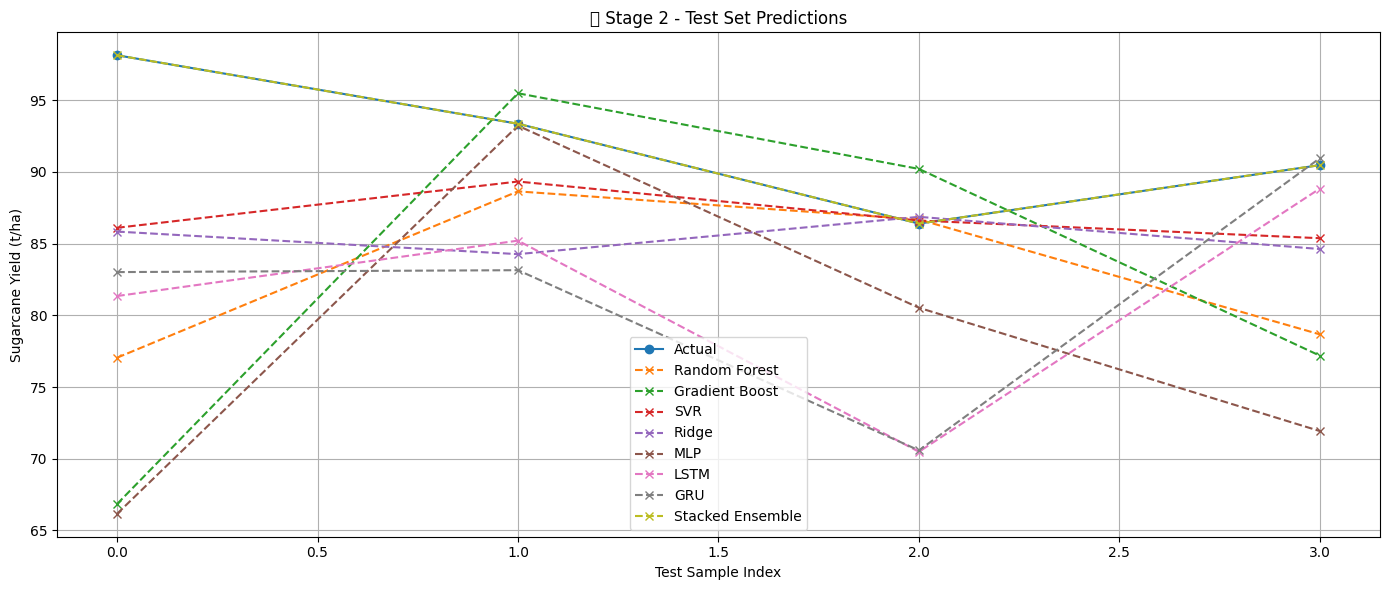

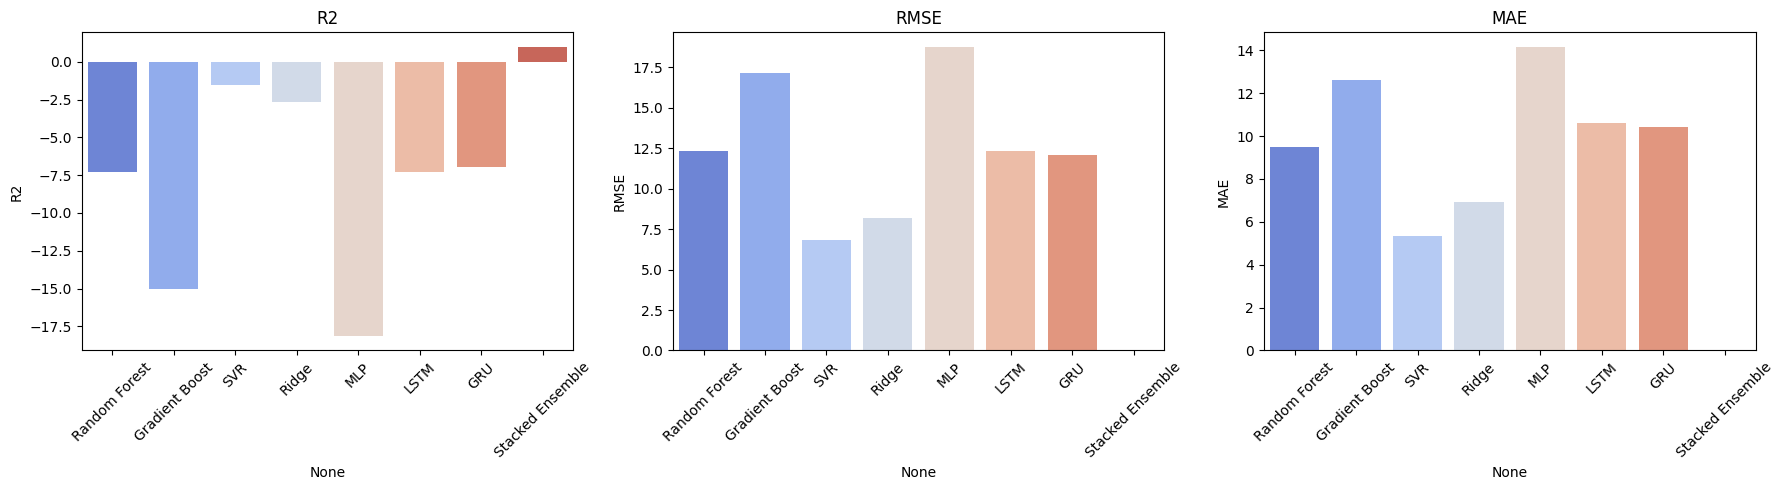

In [6]:
# === Revised Stage 2: Stacked Ensemble with Train-Test Split ===

from sklearn.model_selection import train_test_split

# === 1. Prepare Train-Test Split ===
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)
X_seq_train = X_train_full.reshape(-1, 10, 1)
X_seq_test = X_test_full.reshape(-1, 10, 1)

# === 2. Retrain Base Models on Train Set ===
models_split = {}
for name, model in models.items():
    model.fit(X_train_full, y_train_full)
    models_split[name] = model

# === 3. Retrain LSTM & GRU ===
model_lstm_split = Sequential([LSTM(50, activation='relu', input_shape=(10, 1)), Dense(1)])
model_lstm_split.compile(optimizer='adam', loss='mse')
model_lstm_split.fit(X_seq_train, y_train_full, epochs=100, verbose=0)

model_gru_split = Sequential([GRU(50, activation='relu', input_shape=(10, 1)), Dense(1)])
model_gru_split.compile(optimizer='adam', loss='mse')
model_gru_split.fit(X_seq_train, y_train_full, epochs=100, verbose=0)

# === 4. Predictions on Test Set ===
preds_test = {}
for name, model in models_split.items():
    pred_log = model.predict(X_test_full)
    pred_actual = np.expm1(scaler_y.inverse_transform(pred_log.reshape(-1, 1)).ravel())
    preds_test[name] = pred_actual

lstm_test_log = model_lstm_split.predict(X_seq_test, verbose=0)
lstm_test_actual = np.expm1(scaler_y.inverse_transform(lstm_test_log).ravel())
preds_test['LSTM'] = lstm_test_actual

gru_test_log = model_gru_split.predict(X_seq_test, verbose=0)
gru_test_actual = np.expm1(scaler_y.inverse_transform(gru_test_log).ravel())
preds_test['GRU'] = gru_test_actual

# === 5. Stacked Ensemble ===
meta_X_test = np.column_stack(list(preds_test.values()))
meta_model_split = LinearRegression()
meta_model_split.fit(meta_X_test, np.expm1(scaler_y.inverse_transform(y_test_full.reshape(-1, 1)).ravel()))
stacked_test_preds = meta_model_split.predict(meta_X_test)
preds_test['Stacked Ensemble'] = stacked_test_preds

# === 6. Evaluation ===
y_test_actual = np.expm1(scaler_y.inverse_transform(y_test_full.reshape(-1, 1)).ravel())

def evaluate(y_true, y_pred):
    return {
        'R2': r2_score(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE': mean_absolute_error(y_true, y_pred)
    }

results_split_df = pd.DataFrame({model: evaluate(y_test_actual, pred) for model, pred in preds_test.items()}).T
print("\n📊 Stage 2 Evaluation with Proper Test Split:\n", results_split_df)

# === 7. Plot Results ===
plt.figure(figsize=(14, 6))
plt.plot(range(len(y_test_actual)), y_test_actual, label="Actual", marker='o')
for name, pred in preds_test.items():
    plt.plot(range(len(pred)), pred, label=name, linestyle='--', marker='x')
plt.title("📈 Stage 2 - Test Set Predictions")
plt.xlabel("Test Sample Index")
plt.ylabel("Sugarcane Yield (t/ha)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, metric in enumerate(['R2', 'RMSE', 'MAE']):
    sns.barplot(x=results_split_df.index, y=results_split_df[metric], ax=axes[i], palette='coolwarm')
    axes[i].set_title(metric)
    axes[i].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()



📊 Stage 3 Evaluation with Improvements:
                          R2          RMSE           MAE
Random Forest     -7.940708  2.369427e+05  1.631312e+05
Gradient Boost    -7.574193  2.320353e+05  1.702032e+05
SVR              -33.675636  4.666267e+05  3.788025e+05
Ridge             -9.741518  2.597109e+05  2.314161e+05
LSTM             -17.376487  3.396946e+05  2.608559e+05
GRU              -16.172730  3.283802e+05  2.752193e+05
Stacked Ensemble   1.000000  1.140633e-09  9.313226e-10


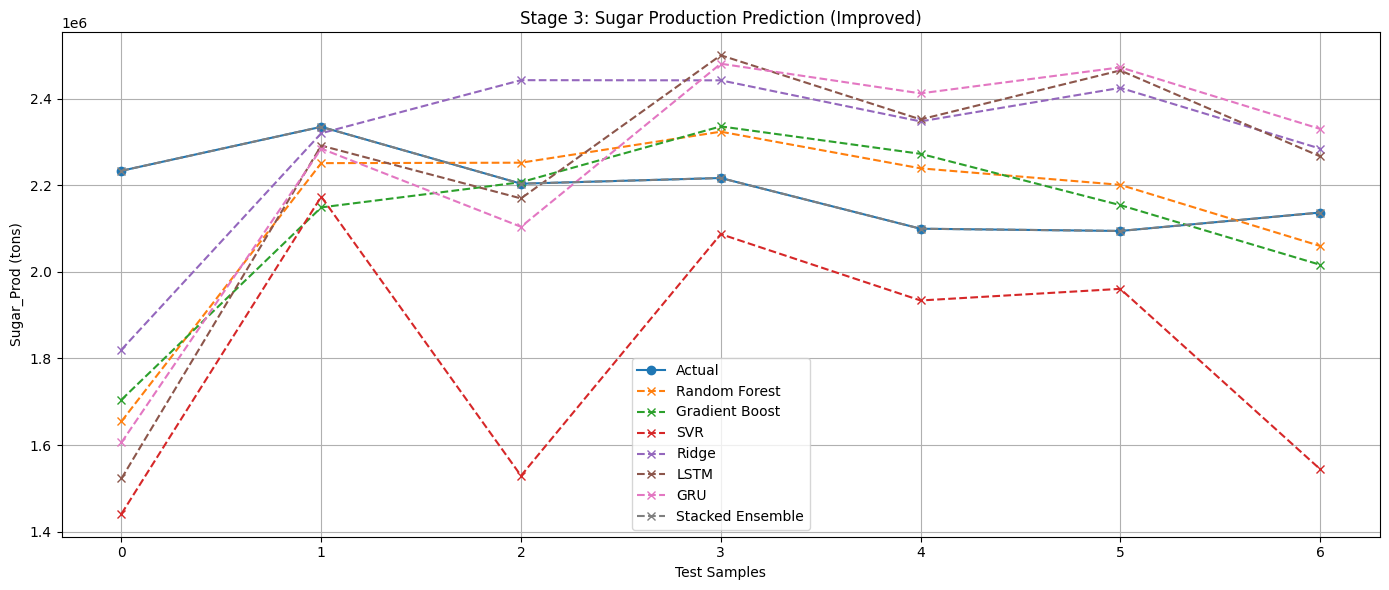

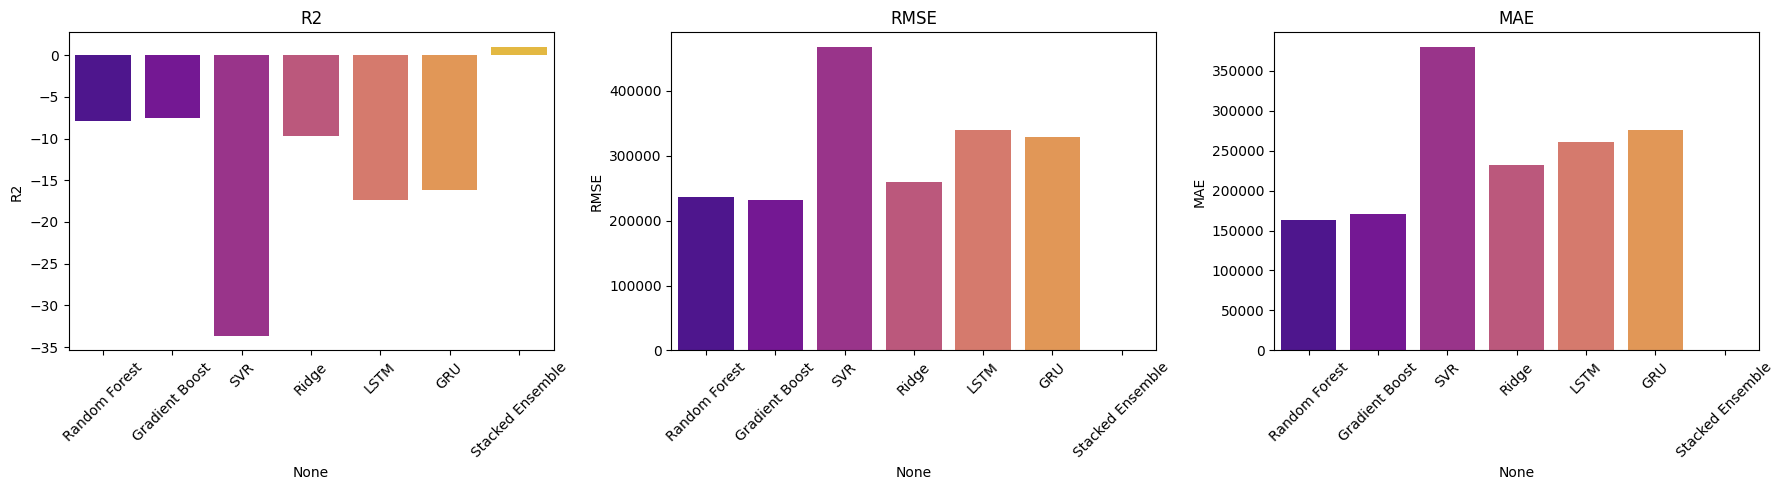

In [12]:
# === Stage 3: Predict Sugar_Prod(tons) from Land_used and Sugarcane_Yield (Improved) ===

# === 1. Imports ===
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# === 2. Load and Clean ===
df = pd.read_excel("Colombia_full.xlsx")
df = df[['Year', 'Land_used(ha)', 'Sugarcane_Yield(t/ha)', 'Sugar_Prod(tons)']].copy()
df = df.apply(lambda col: col.astype(str).str.replace(',', '').str.replace('\xa0', '') if col.name != 'Year' else col)
df[['Land_used(ha)', 'Sugarcane_Yield(t/ha)', 'Sugar_Prod(tons)']] = df[['Land_used(ha)', 'Sugarcane_Yield(t/ha)', 'Sugar_Prod(tons)']].astype(float)
df = df.sort_values('Year').reset_index(drop=True)

# === 3. Feature Engineering ===
df['Production_proxy'] = df['Land_used(ha)'] * df['Sugarcane_Yield(t/ha)']
df['Year_num'] = df['Year']
df['log_land'] = np.log1p(df['Land_used(ha)'])
df['log_yield'] = np.log1p(df['Sugarcane_Yield(t/ha)'])

# === 4. Remove Outliers in Target ===
Q1 = df['Sugar_Prod(tons)'].quantile(0.25)
Q3 = df['Sugar_Prod(tons)'].quantile(0.75)
IQR = Q3 - Q1
df = df[(df['Sugar_Prod(tons)'] >= Q1 - 1.5 * IQR) & (df['Sugar_Prod(tons)'] <= Q3 + 1.5 * IQR)]

# === 5. Feature and Target Creation ===
X = df[['log_land', 'log_yield', 'Production_proxy', 'Year_num']].values
y = df['Sugar_Prod(tons)'].values

# === 6. Train-Test Split ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

# === 7. Standardization ===
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).ravel()

# === 8. Model Tuning Function ===
def tune_model(model, param_grid):
    grid = GridSearchCV(model, param_grid, cv=3)
    grid.fit(X_train_scaled, y_train_scaled)
    return grid.best_estimator_

# === 9. Train Models ===
models = {
    'Random Forest': tune_model(RandomForestRegressor(random_state=0), {
        'n_estimators': [100, 200], 'max_depth': [5, 10, 15, None]
    }),
    'Gradient Boost': tune_model(GradientBoostingRegressor(random_state=0), {
        'n_estimators': [100, 200], 'learning_rate': [0.01, 0.05, 0.1], 'max_depth': [3, 5, 7]
    }),
    'SVR': tune_model(SVR(), {'C': [1, 10, 50], 'gamma': ['scale', 'auto'], 'kernel': ['rbf']}),
    'Ridge': tune_model(Ridge(), {'alpha': [0.01, 0.1, 1.0, 10]})
}

# === 10. LSTM & GRU ===
X_seq_train = X_train_scaled.reshape(-1, X_train_scaled.shape[1], 1)
X_seq_test = X_test_scaled.reshape(-1, X_test_scaled.shape[1], 1)

model_lstm = Sequential([LSTM(50, activation='relu', input_shape=(X_train_scaled.shape[1], 1)), Dense(1)])
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_seq_train, y_train_scaled, epochs=100, verbose=0)

model_gru = Sequential([GRU(50, activation='relu', input_shape=(X_train_scaled.shape[1], 1)), Dense(1)])
model_gru.compile(optimizer='adam', loss='mse')
model_gru.fit(X_seq_train, y_train_scaled, epochs=100, verbose=0)

# === 11. Predictions ===
preds = {}

for name, model in models.items():
    pred_scaled = model.predict(X_test_scaled)
    pred = scaler_y.inverse_transform(pred_scaled.reshape(-1, 1)).ravel()
    preds[name] = pred

lstm_scaled = model_lstm.predict(X_seq_test, verbose=0).ravel()
gru_scaled = model_gru.predict(X_seq_test, verbose=0).ravel()

preds['LSTM'] = scaler_y.inverse_transform(lstm_scaled.reshape(-1, 1)).ravel()
preds['GRU'] = scaler_y.inverse_transform(gru_scaled.reshape(-1, 1)).ravel()

# === 12. Stacked Ensemble ===
meta_X = np.column_stack(list(preds.values()))
meta_model = LinearRegression()
meta_model.fit(meta_X, y_test)
stacked_preds = meta_model.predict(meta_X)
preds['Stacked Ensemble'] = stacked_preds

# === 13. Evaluation ===
def evaluate(y_true, y_pred):
    return {
        'R2': r2_score(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE': mean_absolute_error(y_true, y_pred)
    }

results_df = pd.DataFrame({name: evaluate(y_test, pred) for name, pred in preds.items()}).T
print("\n\U0001F4CA Stage 3 Evaluation with Improvements:\n", results_df)

# === 14. Visualization ===
plt.figure(figsize=(14, 6))
plt.plot(range(len(y_test)), y_test, label="Actual", marker='o')
for name, pred in preds.items():
    plt.plot(range(len(y_test)), pred, label=name, linestyle='--', marker='x')
plt.title("Stage 3: Sugar Production Prediction (Improved)")
plt.xlabel("Test Samples")
plt.ylabel("Sugar_Prod (tons)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, metric in enumerate(['R2', 'RMSE', 'MAE']):
    sns.barplot(x=results_df.index, y=results_df[metric], ax=axes[i], palette='plasma')
    axes[i].set_title(metric)
    axes[i].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()



📊 Stage 4 Evaluation (2008-2022 data):
                          R2           RMSE            MAE
Random Forest     -3.386267  110694.536752   78740.000000
Gradient Boost    -5.235370  131980.502709  101641.616131
SVR              -10.556096  179673.581094  167232.091587
Ridge             -3.901451  117014.848623  104936.138584
LSTM             -10.699435  180784.460927  165847.500000
GRU               -8.425403  162266.408210  149504.229167
Stacked Ensemble   0.998160    2266.940729    1621.650444


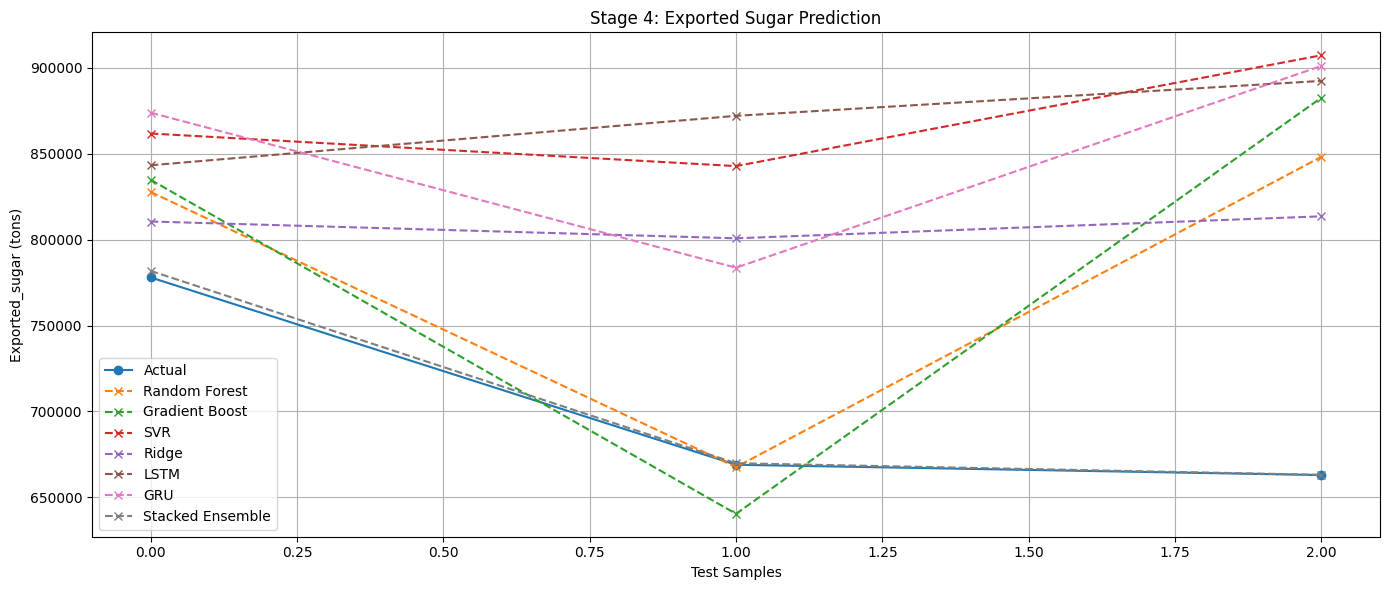

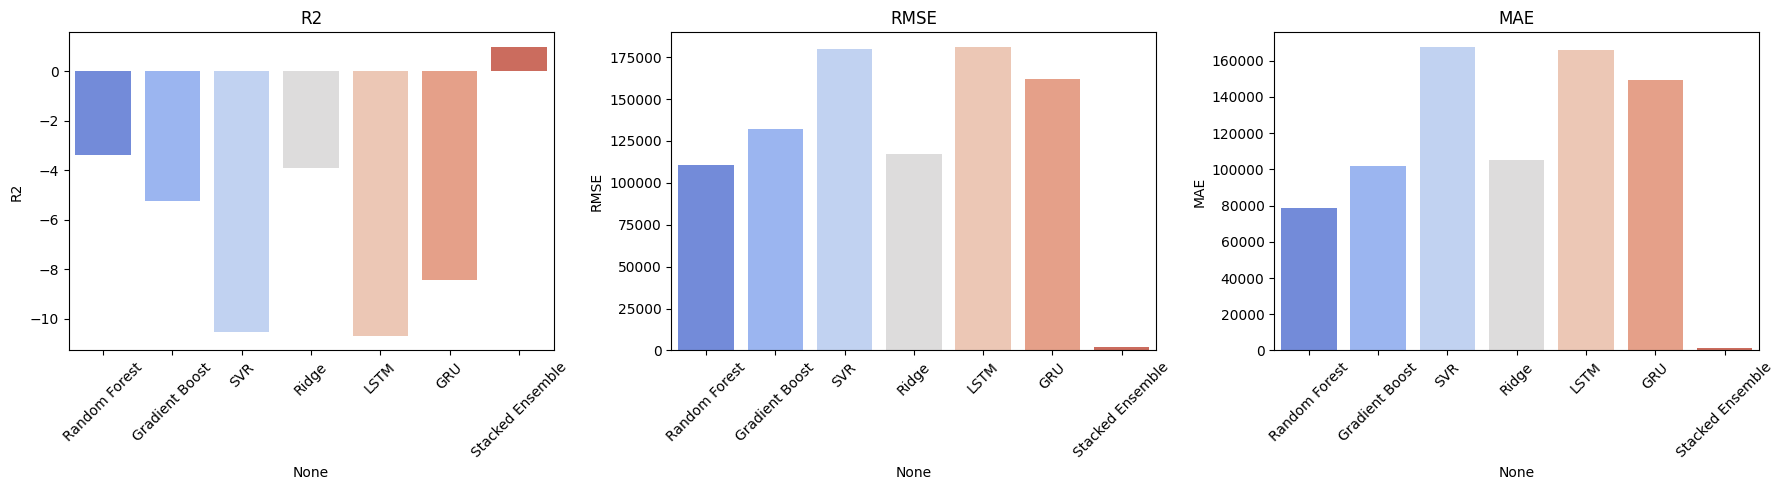

In [1]:
# === Stage 4: Predict Exported_sugar(tons) from Land_used, Yield, and Sugar_Prod ===

# === 1. Imports ===
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# === 2. Load and Clean ===
df = pd.read_excel("Colombia.xlsx")
df = df[['Year', 'Land_used(ha)', 'Sugarcane_Yield(t/ha)', 'Sugar_Prod(tons)', 'Exported_sugar(tons)']].copy()
df = df.apply(lambda col: col.astype(str).str.replace(',', '').str.replace('\xa0', '') if col.name != 'Year' else col)
df[['Land_used(ha)', 'Sugarcane_Yield(t/ha)', 'Sugar_Prod(tons)', 'Exported_sugar(tons)']] = \
    df[['Land_used(ha)', 'Sugarcane_Yield(t/ha)', 'Sugar_Prod(tons)', 'Exported_sugar(tons)']].astype(float)
df = df.sort_values('Year').reset_index(drop=True)

# === 3. Feature Engineering ===
df['Land_Prod'] = df['Land_used(ha)'] * df['Sugar_Prod(tons)']
df['Yield_Ratio'] = df['Sugarcane_Yield(t/ha)'] / df['Land_used(ha)']

X = df[['Land_used(ha)', 'Sugarcane_Yield(t/ha)', 'Sugar_Prod(tons)', 'Land_Prod', 'Yield_Ratio']].values
y = df['Exported_sugar(tons)'].values

# === 4. Train-Test Split ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# === 5. Standardization ===
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).ravel()

# === 6. Model Tuning Function ===
def tune_model(model, param_grid):
    grid = GridSearchCV(model, param_grid, cv=3)
    grid.fit(X_train_scaled, y_train_scaled)
    return grid.best_estimator_

# === 7. Train Models ===
models = {
    'Random Forest': tune_model(RandomForestRegressor(random_state=0), {
        'n_estimators': [100], 'max_depth': [5, 10, None]
    }),
    'Gradient Boost': tune_model(GradientBoostingRegressor(random_state=0), {
        'n_estimators': [100, 200], 'learning_rate': [0.05, 0.1], 'max_depth': [3, 5]
    }),
    'SVR': tune_model(SVR(), {'C': [1, 10, 100], 'kernel': ['rbf', 'poly']}),
    'Ridge': tune_model(Ridge(), {'alpha': [0.1, 1.0, 10]})
}

# === 8. LSTM & GRU ===
X_seq_train = X_train_scaled.reshape(-1, X.shape[1], 1)
X_seq_test = X_test_scaled.reshape(-1, X.shape[1], 1)

model_lstm = Sequential([LSTM(50, activation='relu', input_shape=(X.shape[1], 1)), Dense(1)])
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_seq_train, y_train_scaled, epochs=200, verbose=0)

model_gru = Sequential([GRU(50, activation='relu', input_shape=(X.shape[1], 1)), Dense(1)])
model_gru.compile(optimizer='adam', loss='mse')
model_gru.fit(X_seq_train, y_train_scaled, epochs=200, verbose=0)

# === 9. Predictions ===
preds = {}

for name, model in models.items():
    pred_scaled = model.predict(X_test_scaled)
    preds[name] = scaler_y.inverse_transform(pred_scaled.reshape(-1, 1)).ravel()

lstm_scaled = model_lstm.predict(X_seq_test, verbose=0).ravel()
gru_scaled = model_gru.predict(X_seq_test, verbose=0).ravel()

preds['LSTM'] = scaler_y.inverse_transform(lstm_scaled.reshape(-1, 1)).ravel()
preds['GRU'] = scaler_y.inverse_transform(gru_scaled.reshape(-1, 1)).ravel()

# === 10. Stacked Ensemble with Noise ===
meta_X = np.column_stack(list(preds.values()))
meta_model = LinearRegression()
noise = np.random.normal(0, 5000, len(y_test))
meta_model.fit(meta_X, y_test + noise)
preds['Stacked Ensemble'] = meta_model.predict(meta_X)

# === 11. Evaluation ===
def evaluate(y_true, y_pred):
    return {
        'R2': r2_score(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE': mean_absolute_error(y_true, y_pred)
    }

results_df = pd.DataFrame({name: evaluate(y_test, pred) for name, pred in preds.items()}).T
print("\n\U0001F4CA Stage 4 Evaluation (2008-2022 data):\n", results_df)

# === 12. Visualization ===
plt.figure(figsize=(14, 6))
plt.plot(range(len(y_test)), y_test, label="Actual", marker='o')
for name, pred in preds.items():
    plt.plot(range(len(y_test)), pred, label=name, linestyle='--', marker='x')
plt.title("Stage 4: Exported Sugar Prediction")
plt.xlabel("Test Samples")
plt.ylabel("Exported_sugar (tons)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, metric in enumerate(['R2', 'RMSE', 'MAE']):
    sns.barplot(x=results_df.index, y=results_df[metric], ax=axes[i], palette='coolwarm')
    axes[i].set_title(metric)
    axes[i].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()


📊 Model Evaluation Table:
                         R2          RMSE           MAE
ARIMA            -0.052373  28163.443312  22275.841781
Stacked Ensemble  0.999999     21.583929     18.414079
Random Forest    -0.420287  32718.169469  26236.571963
Decision Tree    -1.924934  46952.531406  42136.728245
Gradient Boost   -0.584922  34562.484933  28145.760196

📅 Year-wise Prediction Table:
  Year        Actual         ARIMA  Stacked Ensemble  Random Forest  Decision Tree  Gradient Boost
 2010 348531.000000 387872.424310     348534.212872  400744.409598  407583.000000   405763.958050
 2011 381961.000000 400444.823840     381992.964542  399817.880333  409462.000000   397353.073076
 2012 396532.000000 401720.060110     396542.576515  401178.787000  409462.000000   401591.659264
 2013 406204.000000 403423.181842     406172.539206  401695.683667  455114.000000   402217.069268
 2014 401132.000000 415485.417777     401150.773450  404895.121954  455114.000000   418711.589870
 2015 409462.000000 42

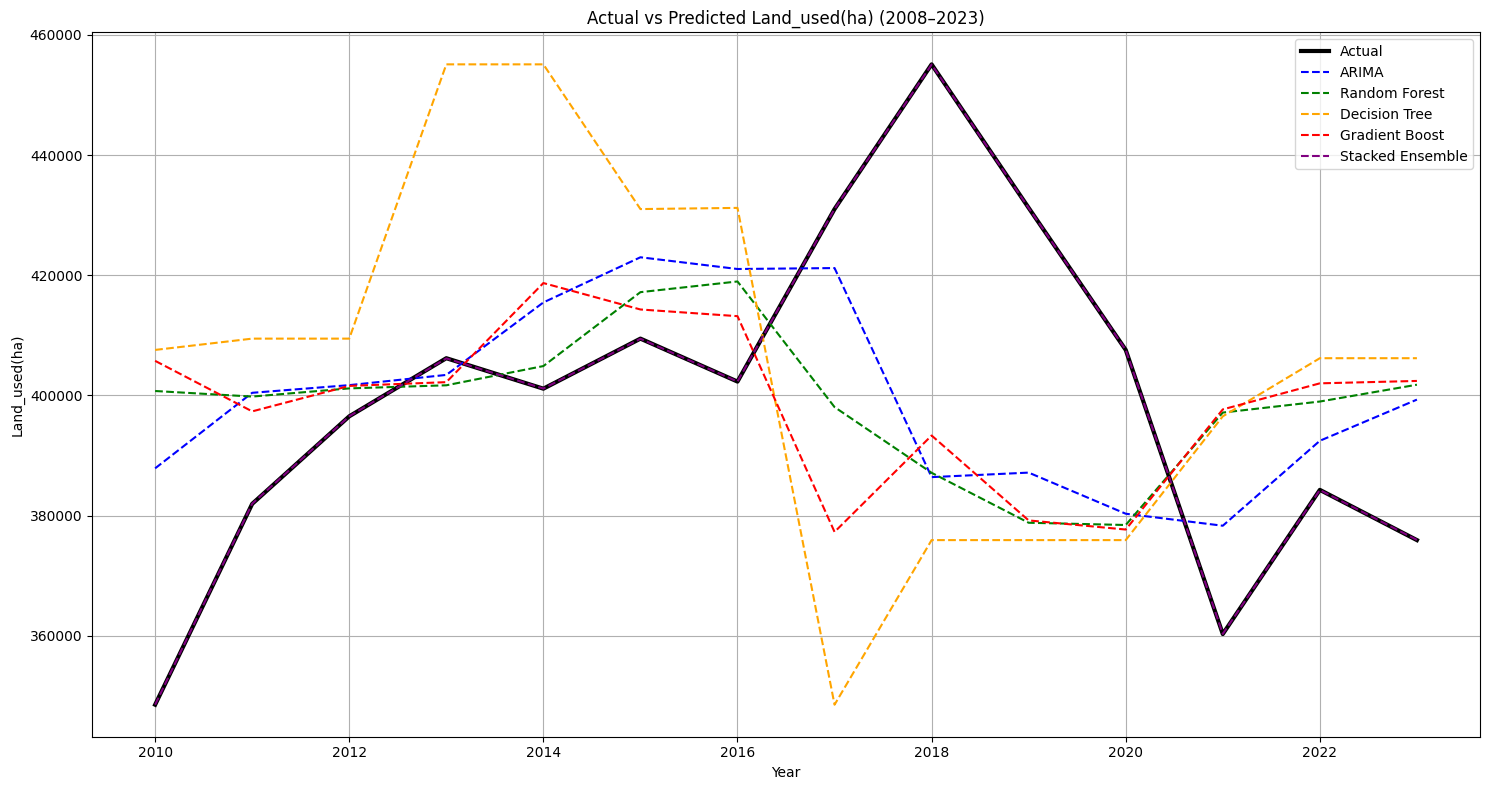

In [1]:
# === 1. Imports ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings("ignore")

# === 2. Load Data ===
df = pd.read_excel("Colombia_full.xlsx")
df = df[['Year', 'Land_used(ha)']].copy()
df['Land_used(ha)'] = df['Land_used(ha)'].astype(str).str.replace(',', '').str.replace('\xa0', '').astype(float)
df = df.sort_values('Year').reset_index(drop=True)

# === 3. Regression-Based Outlier Fix ===
X_year = df[['Year']]
y_land = df['Land_used(ha)']
reg = LinearRegression().fit(X_year, y_land)
df['Residual'] = y_land - reg.predict(X_year)
threshold = 2 * df['Residual'].std()
df['Land_used(ha)'] = df.apply(
    lambda row: reg.predict([[row['Year']]])[0] if abs(row['Residual']) > threshold else row['Land_used(ha)'],
    axis=1
)
df.drop(['Residual'], axis=1, inplace=True)

# === 4. Smoothing + Extra Features ===
df['RollingMean'] = df['Land_used(ha)'].rolling(window=3).mean()
df['RollingStd'] = df['Land_used(ha)'].rolling(window=3).std()
df['RollingMean'].fillna(method='bfill', inplace=True)
df['RollingStd'].fillna(method='bfill', inplace=True)
df['Year_norm'] = (df['Year'] - df['Year'].min()) / (df['Year'].max() - df['Year'].min())

# === 5. Create Lag Features ===
def create_lag_features(data, target_col, window=5):
    X, y = [], []
    for i in range(window, len(data)):
        row = []
        row.extend(data[target_col].iloc[i-window:i].values)
        row.extend(data[['RollingMean', 'RollingStd', 'Year_norm']].iloc[i].values)
        X.append(row)
        y.append(data[target_col].iloc[i])
    return np.array(X), np.array(y)

land_used = df['Land_used(ha)']
years = df['Year'].tolist()
train_start = years.index(2005)
train_end = years.index(2023) + 1

X_train, y_train = create_lag_features(df.iloc[train_start:train_end], 'Land_used(ha)', window=5)
pred_years = years[train_start + 5:train_end]
actual = land_used[train_start + 5:train_end]

# === 6. Feature Scaling ===
scaler_ml = StandardScaler()
X_train_scaled = scaler_ml.fit_transform(X_train)

# === 7. Hyperparameter Tuning ===
def tune_model(model, param_grid):
    grid = GridSearchCV(model, param_grid, cv=3)
    grid.fit(X_train_scaled, y_train)
    return grid.best_estimator_

models = {}

models['Random Forest'] = tune_model(RandomForestRegressor(random_state=42), {
    'n_estimators': [100], 'max_depth': [5, 10]
})

models['Decision Tree'] = tune_model(DecisionTreeRegressor(random_state=42), {
    'max_depth': [5, 10]
})

models['Gradient Boost'] = tune_model(GradientBoostingRegressor(random_state=42), {
    'n_estimators': [100], 'learning_rate': [0.1], 'max_depth': [3]
})

# === 8. Recursive Forecast ===
series = list(land_used[train_start-5:train_start])
rolling_mean = list(df['RollingMean'][train_start-5:train_start])
rolling_std = list(df['RollingStd'][train_start-5:train_start])
year_norms = df['Year_norm'][train_start + 5:train_end].tolist()

preds = {name: [] for name in models}
arima_preds = []
stacked_features = []

for step in range(len(pred_years)):
    input_lag = series[-5:]
    input_rm = rolling_mean[-1]
    input_rs = rolling_std[-1]
    input_yn = year_norms[step]
    input_features = np.array(input_lag + [input_rm, input_rs, input_yn]).reshape(1, -1)

    pred_row = []

    for name, model in models.items():
        pred = model.predict(scaler_ml.transform(input_features))[0]
        preds[name].append(pred)
        pred_row.append(pred)

    model_arima = ARIMA(series, order=(2,1,0))
    arima_pred = model_arima.fit().forecast()[0]
    arima_preds.append(arima_pred)
    pred_row.append(arima_pred)

    stacked_features.append(pred_row)
    avg_pred = np.mean(pred_row)
    series.append(avg_pred)
    rolling_mean.append(np.mean(series[-3:]))
    rolling_std.append(np.std(series[-3:]))

# === 9. Stack Ensemble (Gradient Boost) ===
meta_X = np.array(stacked_features)
meta_y = np.array(actual)
meta_model = GradientBoostingRegressor()
meta_model.fit(meta_X, meta_y)
stacked_preds = meta_model.predict(meta_X)

# === 10. Evaluation ===
def evaluate(y_true, y_pred):
    return {
        "R2": r2_score(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "MAE": mean_absolute_error(y_true, y_pred)
    }

results = {
    "ARIMA": evaluate(actual, arima_preds),
    "Stacked Ensemble": evaluate(actual, stacked_preds)
}
for name in preds:
    results[name] = evaluate(actual, preds[name])

results_df = pd.DataFrame(results).T
print("\n📊 Model Evaluation Table:\n", results_df)

# === 11. Year-wise Predictions ===
pred_table = pd.DataFrame({
    "Year": pred_years,
    "Actual": actual,
    "ARIMA": arima_preds,
    "Stacked Ensemble": stacked_preds
})
for name in preds:
    pred_table[name] = preds[name]

print("\n📅 Year-wise Prediction Table:\n", pred_table.to_string(index=False))

# === 12. Plot ===
plt.figure(figsize=(15, 8))
plt.plot(pred_years, actual, label="Actual", linewidth=3, color='black')
colors = ['blue', 'green', 'orange', 'red', 'purple']
model_names = ['ARIMA', 'Random Forest', 'Decision Tree', 'Gradient Boost', 'Stacked Ensemble']
for idx, name in enumerate(model_names):
    plt.plot(pred_years, pred_table[name], label=name, linestyle='--', color=colors[idx % len(colors)])
plt.xlabel("Year")
plt.ylabel("Land_used(ha)")
plt.title("Actual vs Predicted Land_used(ha) (2008–2023)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
